# Analysis Scripts for RMP Data

In [1]:
# %% Import JAX and enable 64-bit precision
import jax
jax.config.update("jax_enable_x64", True)

In [2]:
# %% Import other libraries
import equinox as eqx
import interpax
import diffrax
import optimistix as optx

import numpy as np
import jax.numpy as jnp
import jax.tree_util as jtu
from dataclasses import dataclass
from functools import partial
import numpy as np
from collections import namedtuple
from typing import NamedTuple
import matplotlib.pyplot as plt
import matplotlib as mpl

from netCDF4 import Dataset

from jaxtyping import ArrayLike, Real
from tqdm.notebook import tqdm

In [15]:
# %% Load my own libraries
%load_ext autoreload
%autoreload 2
from c1lgkt.jax.fields.equilibrium import Equilibrium
import c1lgkt.jax.fields.clebsch
from c1lgkt.jax.fields.clebsch import ClebschMappingBuilder, ThetaMapping
from c1lgkt.jax.fields.field_providers import RZFourierFieldProvider
import c1lgkt.jax.particles.particle_motion as particle_motion
import c1lgkt.jax.particles.particle_tools as particle_tools
from c1lgkt.jax.analysis.wba import wba_weights

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# %% Load equilibrium and set up clebsch mapping
eq = Equilibrium.from_gfile('./scratch/data/g204386.03600')

clebsch_builder = ClebschMappingBuilder()
theta_map = clebsch_builder.build_theta_map(eq)
clebsch = clebsch_builder.build_clebsch(theta_map, eq)

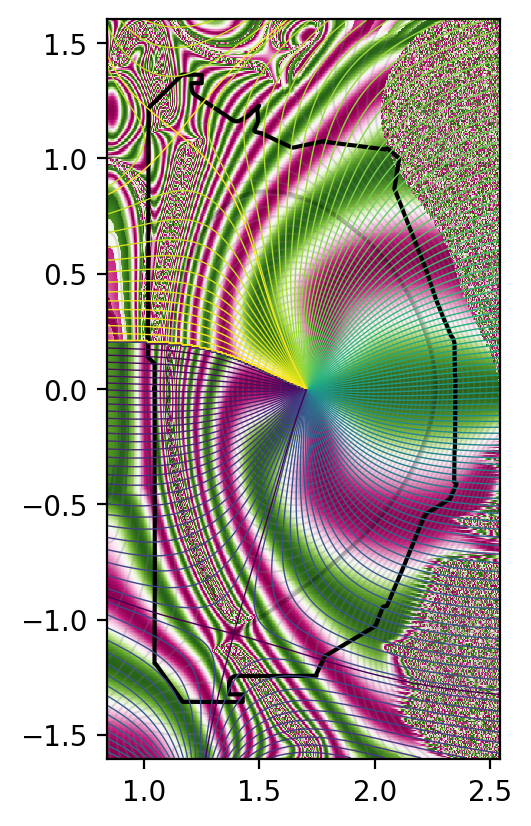

In [5]:
# %% Check the Clebsch variable
plt.figure(dpi=200)

rplot, zplot = jnp.meshgrid(jnp.linspace(eq.rmin, eq.rmax, 512), jnp.linspace(eq.zmin, eq.zmax, 512), indexing='ij')
psiplot = eq.interp_psi(rplot.ravel(), zplot.ravel()).reshape(rplot.shape)
#y0_refine_test = jnp.array([sol.value[0], sol.value[1], sol.value[2], sol.value[3], -1.0, 0.0, 0.0, 0.0])
nulls = theta_map.nulls
thetaplot2 = theta_map(rplot.ravel(), zplot.ravel()).reshape(rplot.shape)
theta_x = theta_map(jnp.array([nulls.x1.rz[0], nulls.x2.rz[0]]), jnp.array([nulls.x1.rz[1], nulls.x2.rz[1]]))

alphaplot = clebsch.interp_alpha(psiplot.ravel(), thetaplot2.ravel()).reshape(rplot.shape)

ax = plt.subplot(111)
eq.plot_magnetic_geometry(ax, alpha=0.25)
ax.scatter(theta_map.nulls.axis.rz[0], theta_map.nulls.axis.rz[1], c='r', s=5)
ax.scatter(theta_map.nulls.x1.rz[0], theta_map.nulls.x1.rz[1], c='r', s=5)
ax.scatter(theta_map.nulls.x2.rz[0], theta_map.nulls.x2.rz[1], c='r', s=5)
#plt.contour(rplot, zplot, thetaplot, levels=jnp.linspace(-np.pi, np.pi, 129), linewidths=0.5, linestyles='dashed')
plt.contour(rplot, zplot, thetaplot2, levels=jnp.linspace(-np.pi, np.pi, 129), linewidths=0.5)
plt.contour(rplot, zplot, thetaplot2, levels=theta_x, linewidths=0.5)
plt.pcolormesh(rplot, zplot, jnp.cos(3*alphaplot), linewidths=0.5, cmap='PiYG')

In [6]:
# %% Load the RMP data
rmp_data = Dataset('./scratch/data/204386_3600_512x12x512_response_data.nc', 'r')
#rmp_data = Dataset('./tests/204386_3600_response_data.nc', 'r')

rgrid = rmp_data['R'][:]
zgrid = rmp_data['Z'][:]

#print(rmp_data.variables)

# Compute FFTs of the RMP data (kind of)
keys = ['E_Er', 'E_Ez', 'E_Et', 'del_B_del_Br', 'del_B_del_Bz', 'del_B_del_Bt', 'del_phi', 'del_Apar']

rmp_data_fft = {
    key: np.fft.rfft(rmp_data[key][:,:,:], axis=1) for key in keys
}

print(rmp_data.variables)

{'R': <class 'netCDF4.Variable'>
float64 R(R)
unlimited dimensions: 
current shape = (512,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'PHI': <class 'netCDF4.Variable'>
float64 PHI(PHI)
unlimited dimensions: 
current shape = (12,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'Z': <class 'netCDF4.Variable'>
float64 Z(Z)
unlimited dimensions: 
current shape = (512,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'del_phi': <class 'netCDF4.Variable'>
float64 del_phi(R, PHI, Z)
unlimited dimensions: 
current shape = (512, 12, 512)
filling on, default _FillValue of 9.969209968386869e+36 used, 'del_Apar': <class 'netCDF4.Variable'>
float64 del_Apar(R, PHI, Z)
unlimited dimensions: 
current shape = (512, 12, 512)
filling on, default _FillValue of 9.969209968386869e+36 used, 'B_Br': <class 'netCDF4.Variable'>
float64 B_Br(R, PHI, Z)
unlimited dimensions: 
current shape = (512, 12, 512)
filling on, default _FillValue of 9.969209968386869e+36 us

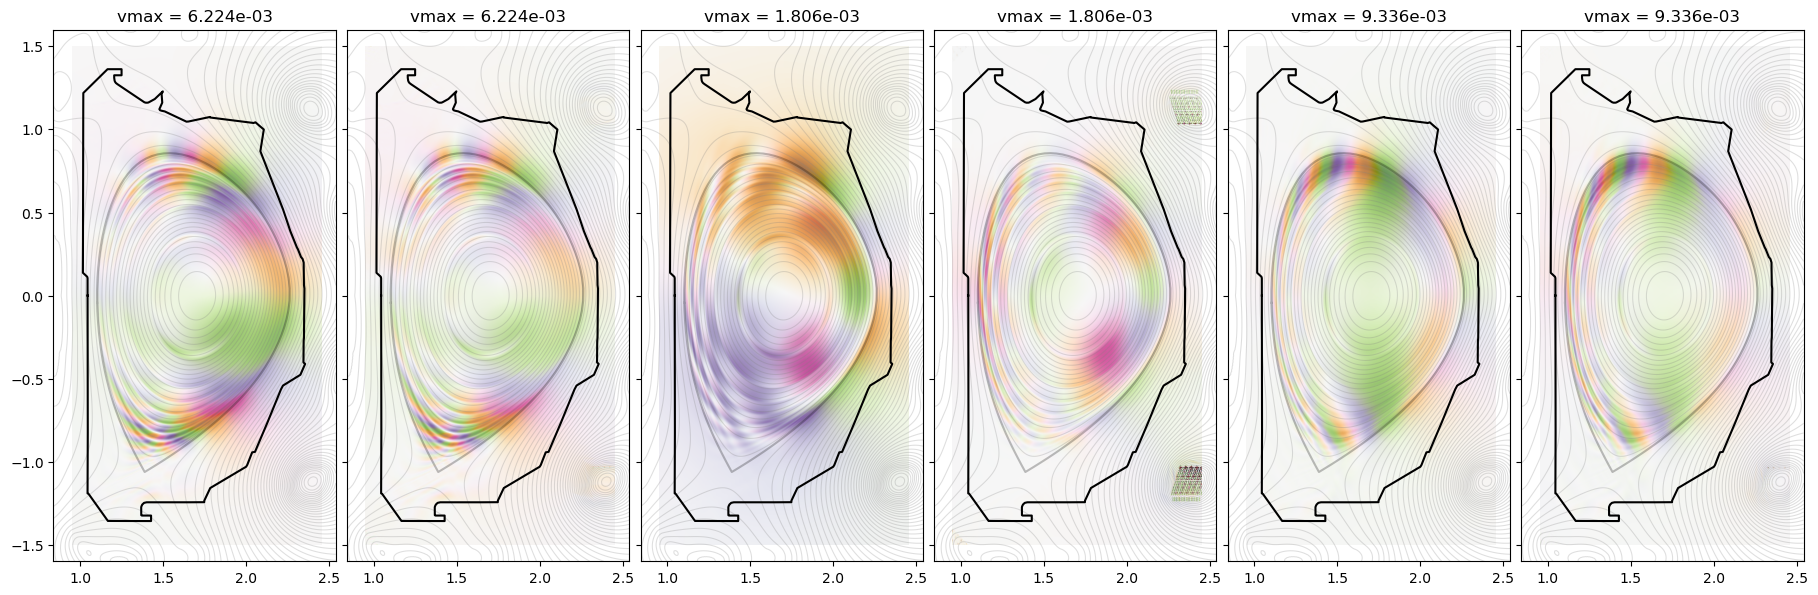

In [7]:

# %% Plot the n=3 component of the RMP fields computed from A_parallel
#plt.figure(dpi=300)

# Set up interpolators
apar = jnp.array(rmp_data_fft['del_Apar'][:,3,:])
interp_apar = interpax.Interpolator2D(rgrid.filled(), zgrid.filled(), jnp.array([-apar]).transpose(1, 2, 0), method='cubic2')
interp_phi = interpax.Interpolator2D(rgrid.filled(), zgrid.filled(), jnp.array([rmp_data_fft['del_phi'][:,3,:]]).transpose(1, 2, 0), method='cubic2')

rmp_field_provider = RZFourierFieldProvider(
    n = jnp.array([3]),
    omega = jnp.array([0.0]),
    interp_phi_coefs = interp_phi,
    interp_apar_coefs = interp_apar,
)

# Compute the RMP fields from A_parallel
rplot, zplot = jnp.meshgrid(rgrid.filled(), zgrid.filled(), indexing='ij')
rflat, zflat = rplot.flatten(), zplot.flatten()

psi_ev, ff_ev = eq.compute_psi_and_ff(rflat, zflat)
bv, bu, modb, gradmodb, curlbu = eq.compute_geom_terms(rflat, psi_ev, ff_ev)

field_eval_re = rmp_field_provider.value_and_grad(0.0, rflat, jnp.zeros_like(rflat), zflat, psi_ev)
field_eval_im = rmp_field_provider.value_and_grad(0.0, rflat, jnp.full_like(rflat, jnp.pi/6), zflat, psi_ev)

# Combine the real and imaginary parts into a complex field
field_eval = jtu.tree_map(lambda re, im: re + 1j * im, field_eval_re, field_eval_im)

# Unpack fields
(phi_flat, apar_flat), ((dphi_dr, dphi_dvarphi, dphi_dz), (dapar_dr, dapar_dvarphi, dapar_dz)) = field_eval

# %% Actually compare fields
nabla_apar = jnp.array([dapar_dr, dapar_dvarphi / rflat, dapar_dz])
del_b = jnp.cross(nabla_apar, bv, axis=0) + apar_flat * curlbu

## Plot
def reim_color(z, vmax):
    #vmax = jnp.max(jnp.abs(z))
    norm = mpl.colors.CenteredNorm(halfrange=vmax)
    real_part = mpl.cm.PiYG(norm(jnp.real(z)))
    imag_part = mpl.cm.PuOr(norm(jnp.imag(z)))
    # Blend the real and imaginary parts together
    blended = 1.0 - jnp.sqrt(((1.0-real_part)**2 + (1.0-imag_part)**2)/2)
    return blended

fig, axs = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(18, 6), dpi=100)

for i, key in enumerate(['del_B_del_Br', 'del_B_del_Bt', 'del_B_del_Bz']):
    vmax = jnp.max(jnp.abs(rmp_data_fft[key][:,3,:]))

    ax = axs[2*i + 0]
    ax.imshow(reim_color(rmp_data_fft[key][:,3,:].T, vmax=vmax), extent=(rgrid[0], rgrid[-1], zgrid[0], zgrid[-1]), origin='lower', aspect='equal')
    ax.set_title(f'vmax = {vmax:.3e}')
    eq.plot_magnetic_geometry(ax, alpha=0.25)

    ax = axs[2*i + 1]
    ax.imshow(reim_color(del_b[i,:].reshape(rplot.shape).T * (2*jnp.pi/12), vmax=vmax), extent=(rgrid[0], rgrid[-1], zgrid[0], zgrid[-1]), origin='lower', aspect='equal')
    #vmax = jnp.max(jnp.abs(del_b[i,:]))
    ax.set_title(f'vmax = {vmax:.3e}')
    eq.plot_magnetic_geometry(ax, alpha=0.25)

    
    
    

plt.tight_layout(pad=0.0)
plt.show()

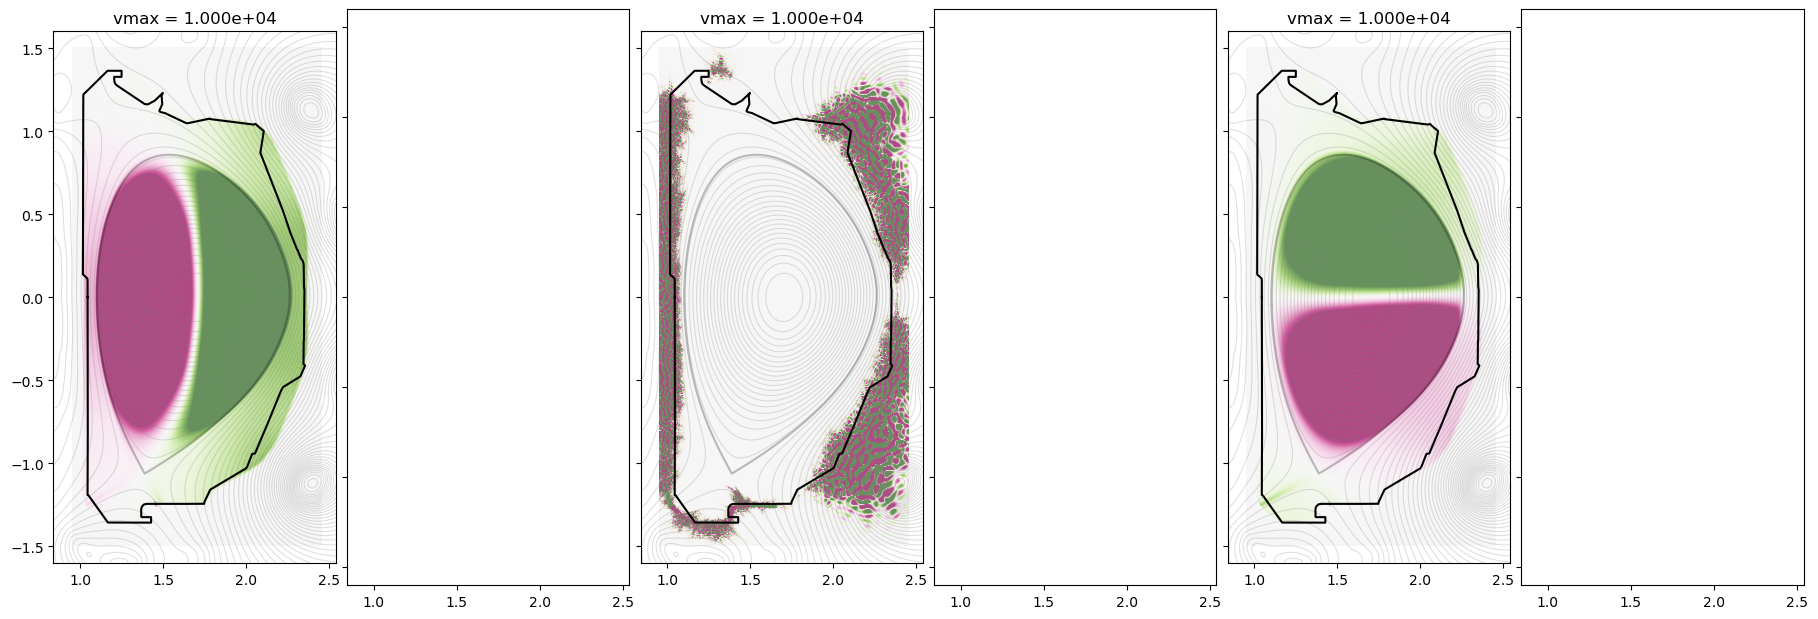

In [8]:
# %% Plot electric field components

fig, axs = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(18, 6), dpi=100)

for i, key in enumerate(['E_Er', 'E_Et', 'E_Ez']):
    vmax = 1e4
    ax = axs[2*i + 0]
    ax.imshow(reim_color(rmp_data_fft[key][:,0,:].T, vmax=vmax), extent=(rgrid[0], rgrid[-1], zgrid[0], zgrid[-1]), origin='lower', aspect='equal')
    ax.set_title(f'vmax = {vmax:.3e}')
    eq.plot_magnetic_geometry(ax, alpha=0.25)

plt.tight_layout(pad=0.0)
plt.show()

In [9]:
# %% Pusher for drift-kinetic particles
pp = particle_motion.elec

# Set up ODE
term = diffrax.ODETerm(particle_motion.f_driftkinetic)
solver = diffrax.Dopri5()
saveat = diffrax.SaveAt(t0=True, t1=True, steps=True)
# TODO: figure out what to do about the electrostatic fields; for now, ignore them
args = particle_motion.PusherArgs(eq=eq, pp=pp, fields=[rmp_field_provider])
stepsize_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8)

num_particles = 32
# Set up initial conditions
y0 = (
    jnp.linspace(jnp.max(eq.lcfsrz[0,:])-0.08, jnp.max(eq.lcfsrz[0,:])-0.005, num_particles),
    jnp.zeros(num_particles),
    jnp.zeros(num_particles),
    jnp.ones(num_particles) * pp.vt,
    jnp.ones(num_particles) * pp.m * pp.vt**2 * 0.1
)
t0 = 0.0

# Test f_driftkinetic
dy0 = particle_motion.f_driftkinetic(0.0, y0, args)

In [12]:
# %% Integrate particle trajectories in blocks and compute punctures

num_blocks = 8
ppuncs = [particle_tools.PunctureData(
    tp = np.zeros((0,)),
    yp = jax.tree.map(lambda x: np.zeros((0,)), y0)
)] * y0[0].shape[0]
npuncs = [particle_tools.PunctureData(
    tp = np.zeros((0,)),
    yp = jax.tree.map(lambda x: np.zeros((0,)), y0)
)] * y0[0].shape[0]


for i in tqdm(range(num_blocks)):
    # Integrate particle trajectories
    sol = diffrax.diffeqsolve(
        term, solver, t0=t0, t1=1000.0, dt0=2e-6, y0=y0,
        args=args, stepsize_controller=diffrax.ConstantStepSize(), saveat=saveat,
        max_steps=4096,
        throw=False
    )

    # Extract solution and compute punctures
    r_sol, varphi_sol, z_sol, vpar_sol, mu_sol = sol.ys # pyright: ignore
    ppuncs_i, npuncs_i = particle_tools.compute_punctures(sol.ts, sol.ys, varphi_sol, period=2*jnp.pi/3) # pyright: ignore

    # Accumulate punctures
    ppuncs = jax.tree.map(lambda *xs: jnp.concatenate(xs), ppuncs, ppuncs_i)
    npuncs = jax.tree.map(lambda *xs: jnp.concatenate(xs), npuncs, npuncs_i)

    # Update initial conditions for next block
    t0 = sol.ts[-1] # pyright: ignore
    y0 = (
        r_sol[-1],
        varphi_sol[-1],
        z_sol[-1],
        vpar_sol[-1],
        mu_sol[-1]
    )





  0%|          | 0/8 [00:00<?, ?it/s]

c:\Users\maple\miniconda3\envs\jax\Lib\site-packages\equinox\_jit.py:55: UserWarning: Complex dtype support in Diffrax is a work in progress and may not yet produce correct results. Consider splitting your computation into real and imaginary parts instead.
  out = fun(*args, **kwargs)


c:\Users\maple\OneDrive\Research\IFS\Scripts\c1lgkt-jax\src\c1lgkt\jax\analysis\wba.py:23: RuntimeWarning: divide by zero encountered in divide
  weights[1:] = np.exp(-1.0 / (s * (1.0 - s)))


ValueError: could not broadcast input array from shape (473,) into shape (472,)

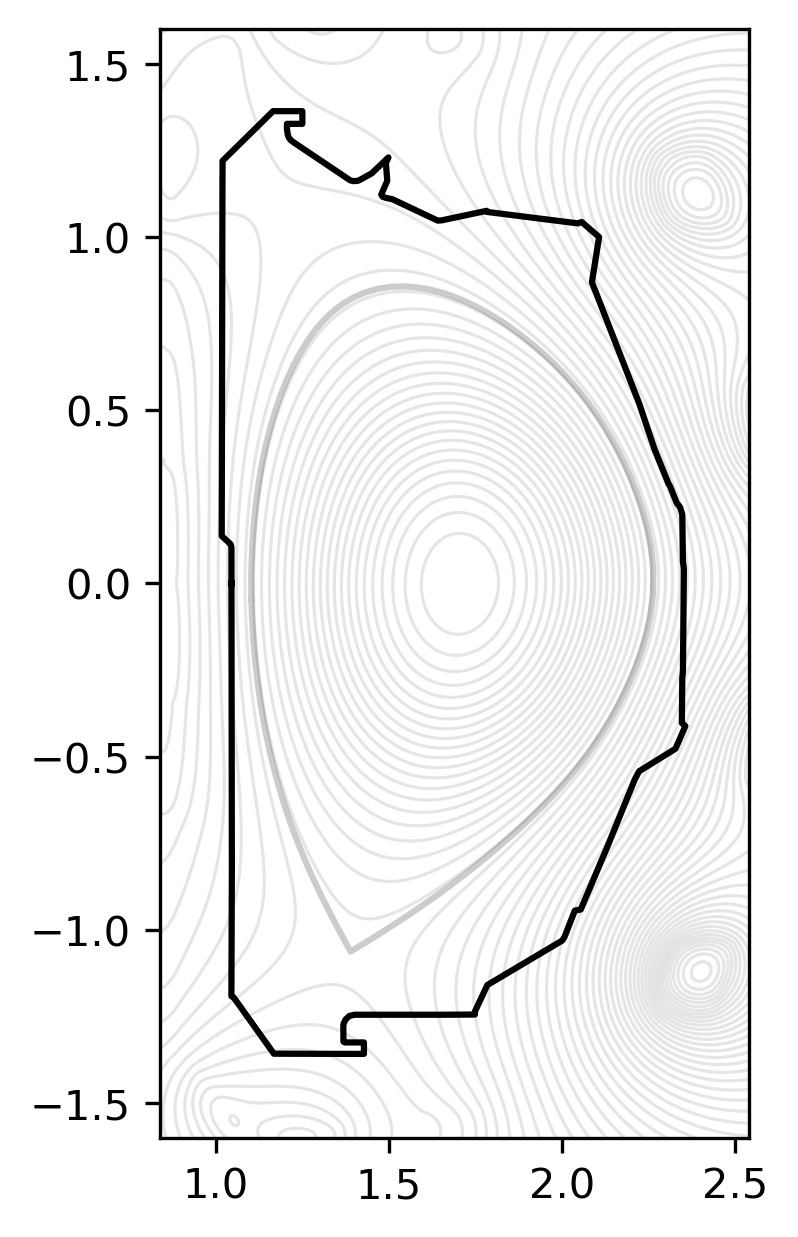

In [ ]:
# %% Plot punctures colored by digits of accuracy computed via WBA
import matplotlib as mpl

plt.figure(dpi=300)

ax = plt.subplot(111)
eq.plot_magnetic_geometry(ax, alpha=0.2)
for k in range(r_sol.shape[1]):
    punc = npuncs[k]
    r_p, varphi_p, z_p, vll_p, mu_p = punc.yp
    psi_p = eq.interp_psi(r_p, z_p)

    ## Compute digits of accuracy via WBA

    # First, compute over full interval
    weight = wba_weights(r_p.shape[0])
    avg_psi = np.sum(psi_p * weight)

    # Next, compute over half interval
    weight_half = wba_weights(r_p.shape[0]//2)
    avg_psi_half = np.sum(psi_p[:r_p.shape[0]//2] * weight_half)
    digits = -np.log10(0.5*np.abs((avg_psi - avg_psi_half)/(avg_psi + avg_psi_half)))
    #print(digits)

    plt.scatter(r_p, z_p, s=(72/100.0)**2, lw=0.0, marker='.', color=mpl.cm.viridis(1.0-(digits-3.0)/(9.0-3.0)))